<a href="https://colab.research.google.com/github/Maithraanand/Applied-DL/blob/main/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_helmet_detection_path = kagglehub.dataset_download('andrewmvd/helmet-detection')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/helmet-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/helmet-detection/annotations/BikesHelmets338.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets680.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets62.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets172.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets622.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets477.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets488.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets696.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets71.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets269.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets206.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets705.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets515.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets113.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets546.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets63

Num GPUs Available:  1
Found 764 image files.
['/kaggle/input/helmet-detection/images/BikesHelmets719.png', '/kaggle/input/helmet-detection/images/BikesHelmets219.png', '/kaggle/input/helmet-detection/images/BikesHelmets18.png', '/kaggle/input/helmet-detection/images/BikesHelmets283.png', '/kaggle/input/helmet-detection/images/BikesHelmets277.png']
Loaded 764 images.
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - loss: 0.6923 - val_loss: 0.6892
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6871 - val_loss: 0.6797
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6792 - val_loss: 0.6735
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6733 - val_loss: 0.6730
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6720 - val_loss: 0.6710
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6715 - val_loss: 0.6746
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6713 - val_loss: 0.6714
Epoch 8/100
20/20 ━━━━━━━━━

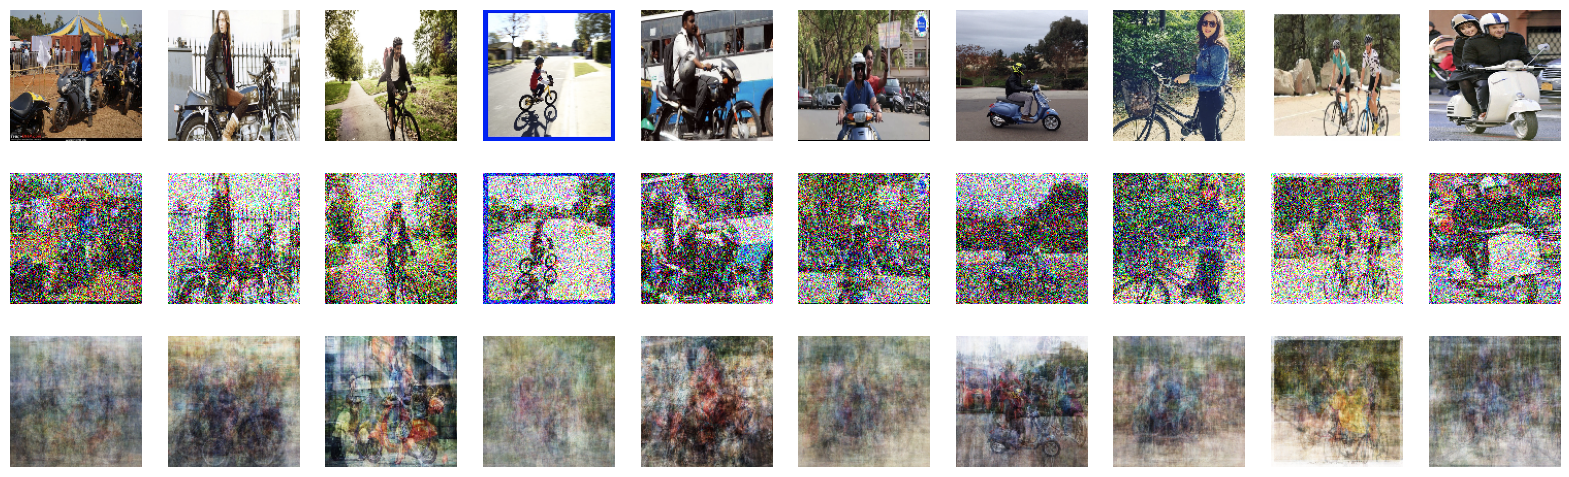

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

# Ensure TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define the dataset path
dataset_path = '/kaggle/input/helmet-detection'

# Handle possible subdirectories and ensure correct image file types are loaded
image_files = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} image files.")  # Print number of images found

# Check the first few image paths
print(image_files[:5])  # Print first 5 image file names to ensure correct files are being loaded

# Load and preprocess the images
img_size = 128  # Resize all images to 128x128
images = []

for img_path in image_files:
    try:
        img = image.load_img(img_path, target_size=(img_size, img_size), color_mode='rgb')
        img_array = image.img_to_array(img)
        img_array = img_array.astype('float32') / 255.  # Normalize to [0, 1]
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

images = np.array(images)

# Check if images are loaded successfully
if images.shape[0] == 0:
    print("No images were loaded. Check your dataset path or image files.")
else:
    print(f"Loaded {images.shape[0]} images.")

# Flatten images to 1D vectors
images_flat = images.reshape((len(images), -1))

# Split into training and test sets
x_train, x_test = train_test_split(images_flat, test_size=0.2, random_state=42)

# Add noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to stay within [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Define the autoencoder architecture
input_img = tf.keras.Input(shape=(img_size * img_size * 3,))  # For RGB images

# Encoder
encoded = tf.keras.layers.Dense(512, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(img_size * img_size * 3, activation='sigmoid')(decoded)  # Output shape (128x128x3)

# Create and compile the model
autoencoder = tf.keras.Model(input_img, decoded)

# Specify GPU usage explicitly (for TensorFlow to ensure GPU acceleration)
with tf.device('/GPU:0'):  # Use the first GPU device (adjust as needed)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Predict denoised images
decoded_imgs = autoencoder.predict(x_test_noisy)

# Visualize some of the original, noisy, and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size, 3))
    plt.axis('off')

    # Display noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(img_size, img_size, 3))
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size, 3))
    plt.axis('off')